# Use hh2 dataset to train a machine learning model

In [1]:
# Data Management/Investigation
import pandas as pd
import numpy as np
import missingno as miss
from plotnine import *
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")

# For pre-processing data 
from sklearn import preprocessing as pp 
from sklearn.compose import ColumnTransformer 

# For splits and CV
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold # Cross validation 
from sklearn.model_selection import cross_validate # Cross validation 
from sklearn.model_selection import GridSearchCV # Cross validation + param. tuning.

# Machine learning methods 
from sklearn.linear_model import LinearRegression as LM
from sklearn.neighbors import KNeighborsRegressor as KNN
from sklearn.tree import DecisionTreeRegressor as DTree
from sklearn import tree # For plotting the decision tree rules
from sklearn.ensemble import BaggingRegressor as Bag
from sklearn.ensemble import RandomForestRegressor as RF

# For evaluating our model's performance
import sklearn.metrics as m

# Pipeline to combine modeling elements
from sklearn.pipeline import Pipeline

In [2]:
# Data Management/Investigation
import pandas as pd
from pandas.api.types import CategoricalDtype # Ordering categories
import numpy as np
import missingno as miss

# Plotting libraries
from plotnine import *
import matplotlib.pyplot as plt

# For pre-processing data 
from sklearn import preprocessing as pp 
from sklearn.compose import ColumnTransformer 

# For splits and CV
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold # Cross validation 
from sklearn.model_selection import cross_validate # Cross validation 
from sklearn.model_selection import GridSearchCV # Cross validation + param. tuning.

# Machine learning methods 
from sklearn.naive_bayes import GaussianNB as NB
from sklearn.neighbors import KNeighborsClassifier as KNN
from sklearn.tree import DecisionTreeClassifier as DT
from sklearn.tree import DecisionTreeRegressor as DT_reg
from sklearn.ensemble import RandomForestClassifier as RF
from sklearn import tree # For plotting the decision tree rules

# For evaluating our model's performance
import sklearn.metrics as m

# Pipeline to combine modeling elements
from sklearn.pipeline import Pipeline

# For model interpretation
from sklearn.inspection import (
    permutation_importance,
    partial_dependence, 
    PartialDependenceDisplay, 
    plot_partial_dependence
)

# Misc
import warnings
warnings.filterwarnings("ignore")

Import Dataset and remove variables where outcome is a nonstarter

In [3]:
hh = pd.read_csv("/Users/xavier/Desktop/DSPP/DS/Data-Science-1-Final-Project/Data_Wrangling/hh3.csv")

In [4]:
hh.shape

(70203, 19)

In [5]:
hh = hh[hh.unbanked >= 0]

In [6]:
#create a 
state = hh.groupby('FIPS').mean()

In [7]:
state["survey_ur"] = state["unemployed"]*100
state["ur_diff"] = state["ST_UR_19"] - state["survey_ur"]
state.ur_diff.mean()

1.5565248511591987

In [8]:
#drop DC
state = state.dropna()

In [9]:
state.reset_index(inplace=True)
state.head()

,FIPS,Unnamed: 0,unbanked,ST_bnk_density,ST_UR_19,income,age,education,bank_prev,poverty,...,unemployed,citizen,native_born,White_or_AAPI,inc_vol,internet,children,single_mother,survey_ur,ur_diff
0,1,25622.359133,0.071207,0.000022,3.0,3.249226,54.461300,2.668731,0.037325,0.153251,...,0.004644,1.041796,1.041796,0.766254,1.196594,0.660991,0.229102,0.086687,0.464396,2.535604
1,2,29113.423295,0.034091,0.000007,5.4,3.880682,48.409091,3.048295,0.022727,0.062500,...,0.011364,1.085227,1.085227,0.778409,1.309659,0.812500,0.312500,0.079545,1.136364,4.263636
2,4,29974.016514,0.040367,0.000002,4.9,3.568807,52.060550,2.935780,0.023853,0.099083,...,0.031193,1.260550,1.260550,0.666055,1.245872,0.807339,0.306422,0.115596,3.119266,1.780734
3,5,31293.446565,0.061069,0.000029,3.5,3.194656,52.625954,2.729008,0.034417,0.145038,...,0.020992,1.070611,1.070611,0.799618,1.208015,0.751908,0.253817,0.122137,2.099237,1.400763
4,6,29786.486600,0.052833,0.000004,4.2,3.782925,52.154288,2.995406,0.019150,0.081547,...,0.027565,1.424579,1.424579,0.651608,1.229709,0.821210,0.276034,0.126340,2.756508,1.443492


Split the data by X and Y and prepare training sample

In [10]:
y = state["unbanked"]
X = state[["ST_bnk_density","ST_UR_19","income","age","education","poverty","under_25","unemployed","citizen","native_born","White_or_AAPI","inc_vol","internet","children","single_mother"]]

In [11]:
train_X, test_X, train_y, test_y = train_test_split(X,y,test_size=.1,random_state=1999)

In [12]:
# Let's scale data
scaler = pp.MinMaxScaler()
col_names = list(train_X)
train_X = scaler.fit_transform(train_X)

In [13]:
# Convert back into data frame
train_X = pd.DataFrame(train_X,columns=col_names)

In [14]:
# (1) Set the folds index to ensure comparable samples
fold_generator = KFold(n_splits=5, shuffle=True,random_state=111)

# (2) Next specify the preprocessing steps
preprocess = ColumnTransformer(transformers=[('num', pp.MinMaxScaler(), ["ST_bnk_density","ST_UR_19","income","age","education","poverty","under_25","unemployed","citizen","native_born","White_or_AAPI","inc_vol","internet","children","single_mother"])])


# (3) Next Let's create our model pipe (note for the model we leave none as a placeholder)
pipe = Pipeline(steps=[('pre_process', preprocess),
                       ('model',None)])


# (4) Specify the models and their repsective tuning parameters. 
# Note the naming convention here to reference the model key
search_space = [
    # Linear Model
    {'model' : [LM()]},
    
    # KNN with K tuning param
    {'model' : [KNN()],
     'model__n_neighbors':[10,15,20,25,30]},
    
    # Decision Tree with the Max Depth Param
    {'model': [DTree()],
     'model__max_depth':[1,2,3,5]},
    
    # The Bagging decision tree model 
    {'model': [Bag()]},
    
    # Random forest with the N Estimators tuning param
    {'model' : [RF()],
     'model__max_depth':[1,2,3],
     'model__n_estimators':[500,1000,1250]},
]


# (5) Put it all together in the grid search
search = GridSearchCV(pipe, search_space, 
                      cv = fold_generator,
                      scoring='neg_mean_squared_error',
                      n_jobs=4)

# (6) Fit the model to the training data
search.fit(train_X,train_y)

GridSearchCV(cv=KFold(n_splits=5, random_state=111, shuffle=True),
             estimator=Pipeline(steps=[('pre_process',
                                        ColumnTransformer(transformers=[('num',
                                                                         MinMaxScaler(),
                                                                         ['ST_bnk_density',
                                                                          'ST_UR_19',
                                                                          'income',
                                                                          'age',
                                                                          'education',
                                                                          'poverty',
                                                                          'under_25',
                                                                          'unemployed',
                    

In [15]:
search.best_score_

-0.00022713547635159803

In [16]:
search.best_params_

{'model': BaggingRegressor()}

In [17]:
#the best model is a random forest so we need to establish it as a variable
dtree = search.best_estimator_

In [18]:
pred_y = search.predict(test_X)

In [19]:
m.mean_squared_error(test_y,pred_y)

0.0004553687963867109

In [20]:
m.r2_score(test_y,pred_y)

-1.7948387837859632

In [21]:
#permute features to determine importances
vi = permutation_importance(dtree,train_X,train_y,n_repeats=25)

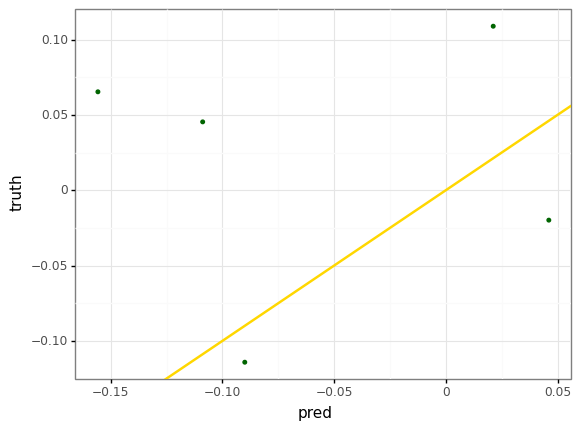

<ggplot: (8761524450169)>

In [22]:
(
    ggplot(pd.DataFrame(dict(pred=pred_y,truth=test_y)),
          aes(x='pred',y="truth")) +
    geom_jitter(color="darkgreen", size=1, width = 0.2, height = 0.2) +
    geom_abline(color="gold",size=1) +
    theme_bw() 
)

Run Decision Tree Seperately since it's the best model

In [23]:
#permute features to determine importances
vi = permutation_importance(dtree,train_X,train_y,n_repeats=25)

In [24]:
# Organize as a data frame 
vi_dat = pd.DataFrame(dict(variable=train_X.columns,
                           vi = vi['importances_mean'],
                           std = vi['importances_std']))

# Generate intervals
vi_dat['low'] = vi_dat['vi'] - 2*vi_dat['std']
vi_dat['high'] = vi_dat['vi'] + 2*vi_dat['std']

# But in order from most to least important
vi_dat = vi_dat.sort_values(by="vi",ascending=False).reset_index(drop=True)


vi_dat

,variable,vi,std,low,high
0,income,0.202294,0.056877,0.088541,0.316047
1,single_mother,0.193177,0.050408,0.092361,0.293993
2,White_or_AAPI,0.147906,0.032973,0.081960,0.213852
3,children,0.036281,0.013799,0.008682,0.063879
4,internet,0.035281,0.009949,0.015382,0.055180
5,age,0.032123,0.007159,0.017804,0.046441
6,ST_bnk_density,0.031241,0.007353,0.016536,0.045946
7,under_25,0.023575,0.005246,0.013084,0.034067
8,education,0.019718,0.006044,0.007630,0.031807
9,ST_UR_19,0.013087,0.005079,0.002930,0.023244
